In [1]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import numpy as np

import gym
import d4rl

from rlkit.torch.networks import Mlp
import seaborn as sns
import matplotlib.pyplot as plt

import matplotlib
matplotlib.rcParams['figure.figsize'] = (15, 10)


No module named 'flow'
(65544) b'X11: The DISPLAY environment variable is missing'
No module named 'carla'


In [2]:
def get_bonus(obs, actions, network, target_network):
    data = torch.cat((obs, actions), dim=1)
    # print('size of data:{}'.format(data.size()))
    
    with torch.no_grad():
        bonus = abs(network(data) - target_network(data))
    # print('size of bonus:{}'.format(bonus.size()))
    
    return bonus

In [3]:
def get_bonus_random_actions(obs, actions, network, target_network):
    action_shape = actions.shape[0]
    obs_shape = obs.shape[0]
    num_repeat = int (action_shape / obs_shape)
    obs_temp = obs.unsqueeze(1).repeat(1, num_repeat, 1).view(obs.shape[0] * num_repeat, obs.shape[1])
    # feed to the bonus networks
    data = torch.cat((obs_temp, actions), dim=1)
    with torch.no_grad():
        bonus = abs(network(data) - target_network(data))
    # reshape
    bonus = bonus.view(obs.shape[0], num_repeat, 1)
    return bonus

In [4]:
def load_models(model_name):
    
    M = 64
    network = Mlp(
        input_size=obs_dim + action_dim,
        output_size=1,
        hidden_sizes=[M, M],
    )

    target_network = Mlp(
    input_size=obs_dim + action_dim,
    output_size=1,
    hidden_sizes=[M, M],
    )
    
    path = '../models/{}'.format(model_name)
    checkpoint = torch.load(path, map_location='cpu')
    network.load_state_dict(checkpoint['network_state_dict'])
    target_network.load_state_dict(checkpoint['target_state_dict'])

    print('Loading model: {}'.format(path))
    
    return network, target_network

In [5]:
num_bins = 100
num_random = 10

# Halfcheetah

In [6]:
env_name = 'walker2d-medium-v0'

env = gym.make(env_name)
obs_dim = env.observation_space.low.size
action_dim = env.action_space.low.size

print(obs_dim)
print(action_dim)

dataset = env.get_dataset()
obs = torch.from_numpy(dataset['observations'])
actions = torch.from_numpy(dataset['actions'])
rewards = dataset['rewards']


/usr/local/google/home/shideh/virtual_env/ML/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


17
6


In [7]:
model_name = 'Nov-19-2020_1043_walker2d-medium-v0.pt'
network_1, target_network_1 = load_models(model_name)
bonus_1 = get_bonus(obs, actions, network_1, target_network_1).detach().cpu().numpy()

Loading model: ../models/Nov-19-2020_1043_walker2d-medium-v0.pt


In [8]:
random_actions = torch.FloatTensor(actions.shape[0] * num_random, actions.shape[-1]).uniform_(-1, 1)
bonus_random_1 = get_bonus_random_actions(obs, random_actions, network_1, target_network_1).detach().cpu().numpy()


In [9]:
ind = np.random.permutation(actions.shape[0])
shuffled_actions = actions[ind]

bonus_shuffled_1 = get_bonus(obs, shuffled_actions, network_1, target_network_1).detach().cpu().numpy()

### STAT = mean

In [10]:
bonus_random_1_mean = np.mean(bonus_random_1, axis=1)
reward_mean = np.mean(rewards)
delta_bonus_1 = abs(bonus_random_1_mean - bonus_1).squeeze(1)

delta_bonus_1_mean = np.mean(delta_bonus_1)
print('mean reward:{}, delta_bonus:{}'.format(reward_mean,delta_bonus_1_mean))
rho1_mean = reward_mean / delta_bonus_1_mean
print('rho1:{0:0.2g}'.format(rho1_mean))


rho2_mean = np.mean(rewards / np.clip(delta_bonus_1, 1e-9, 1e9))
print('rho2:{0:.2g}'.format(rho2_mean))



mean reward:2.6488335132598877, delta_bonus:0.00020368471450638026
rho1:1.3e+04
rho2:1.2e+05


### STAT = median

In [11]:
bonus_random_1_median = np.median(bonus_random_1, axis=1)
reward_median = np.median(rewards)
delta_bonus_1 = abs(bonus_random_1_median - bonus_1).squeeze(1)

delta_bonus_1_median = np.median(delta_bonus_1)
print('median reward:{}, delta_bonus:{}'.format(reward_median,delta_bonus_1_median))
rho1_median = reward_median / delta_bonus_1_median
print('rho1:{0:0.2g}'.format(rho1_median))


rho2_median = np.median(rewards / np.clip(delta_bonus_1, 1e-9, 1e9))
print('rho2:{0:.2g}'.format(rho2_median))

median reward:3.02319598197937, delta_bonus:0.00016303954180330038
rho1:1.9e+04
rho2:1.6e+04


* Histogram of rewards
* Histogram of bonuses
* Histogram of ratio between rewards and bonuses
* Histogram of normalized bonuses before learning


## Histogram of rewards

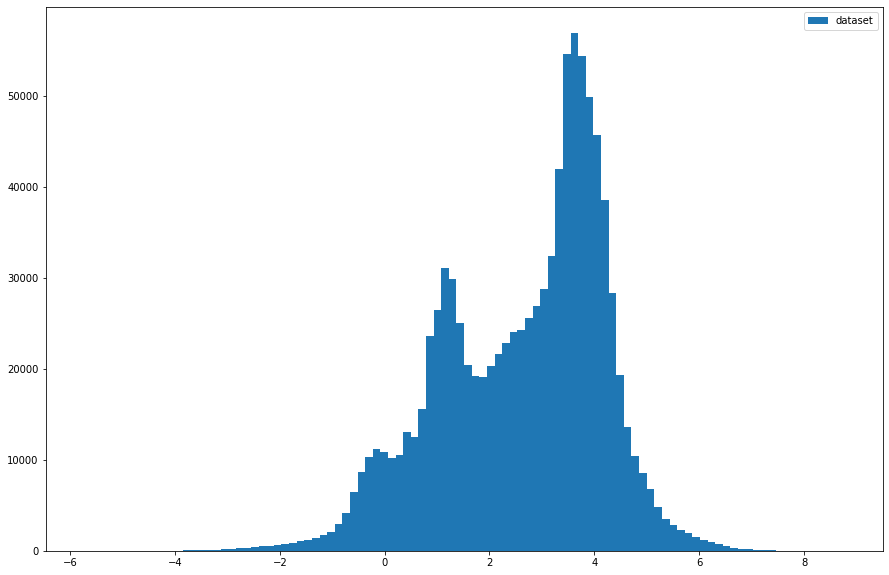

In [13]:
plt.hist(rewards, bins = num_bins, label='dataset')
plt.legend()
matplotlib.rcParams['figure.figsize'] = (5, 5)


# Histogram of Bonuses

Text(0.5, 0.98, 'normalized bonus with rho_1 and mean statistics')

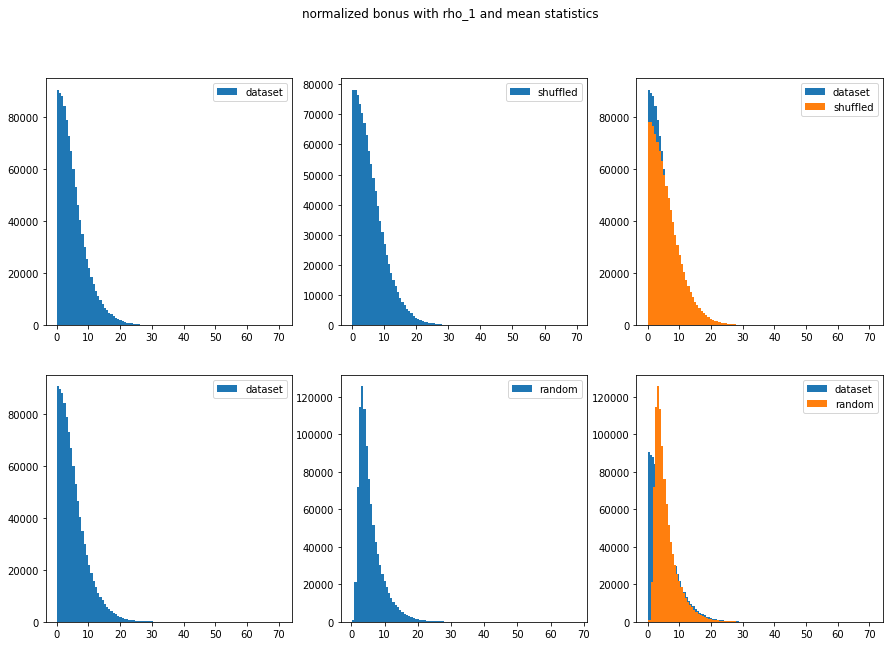

In [14]:
rho = rho1_mean
matplotlib.rcParams['figure.figsize'] = (15, 10)
fig=plt.figure()
plt.subplot(2, 3, 1)
plt.hist(rho * bonus_1, bins = num_bins, label='dataset')
plt.legend()

plt.subplot(2, 3, 2)
plt.hist(rho * bonus_shuffled_1, bins = num_bins, label='shuffled')
plt.legend()

plt.subplot(2, 3, 3)
plt.hist(rho * bonus_1, bins = num_bins, label='dataset')
plt.hist(rho * bonus_shuffled_1, bins = num_bins, label='shuffled')
plt.legend(loc='upper right')


plt.subplot(2, 3, 4)
plt.hist(rho * bonus_1, bins = num_bins, label='dataset')
plt.legend()

plt.subplot(2, 3, 5)
plt.hist(rho * bonus_random_1_mean, bins = num_bins, label='random')
plt.legend()

plt.subplot(2, 3, 6)
plt.hist(rho * bonus_1, bins = num_bins, label='dataset')
plt.hist(rho * bonus_random_1_mean, bins = num_bins, label='random')
plt.legend(loc='upper right')

plt.suptitle('normalized bonus with rho_1 and mean statistics')

Text(0.5, 0.98, 'normalized bonus with rho_2 and mean statistics')

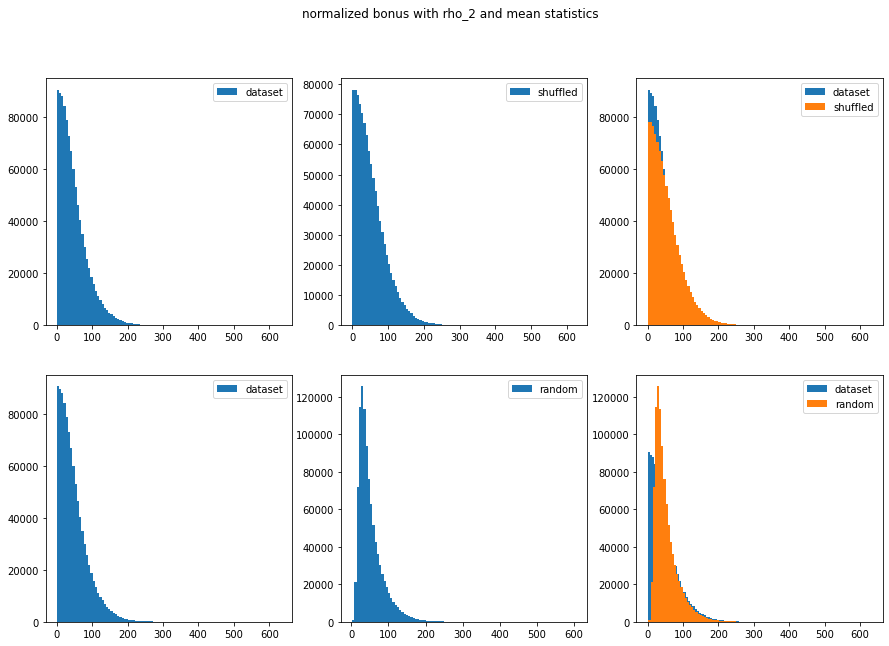

In [15]:
rho = rho2_mean
matplotlib.rcParams['figure.figsize'] = (15, 10)
fig=plt.figure()
plt.subplot(2, 3, 1)
plt.hist(rho * bonus_1, bins = num_bins, label='dataset')
plt.legend()

plt.subplot(2, 3, 2)
plt.hist(rho * bonus_shuffled_1, bins = num_bins, label='shuffled')
plt.legend()

plt.subplot(2, 3, 3)
plt.hist(rho * bonus_1, bins = num_bins, label='dataset')
plt.hist(rho * bonus_shuffled_1, bins = num_bins, label='shuffled')
plt.legend(loc='upper right')


plt.subplot(2, 3, 4)
plt.hist(rho * bonus_1, bins = num_bins, label='dataset')
plt.legend()

plt.subplot(2, 3, 5)
plt.hist(rho * bonus_random_1_mean, bins = num_bins, label='random')
plt.legend()

plt.subplot(2, 3, 6)
plt.hist(rho * bonus_1, bins = num_bins, label='dataset')
plt.hist(rho * bonus_random_1_mean, bins = num_bins, label='random')
plt.legend(loc='upper right')

plt.suptitle('normalized bonus with rho_2 and mean statistics')

Text(0.5, 0.98, 'normalized bonus with rho_1 and median statistics')

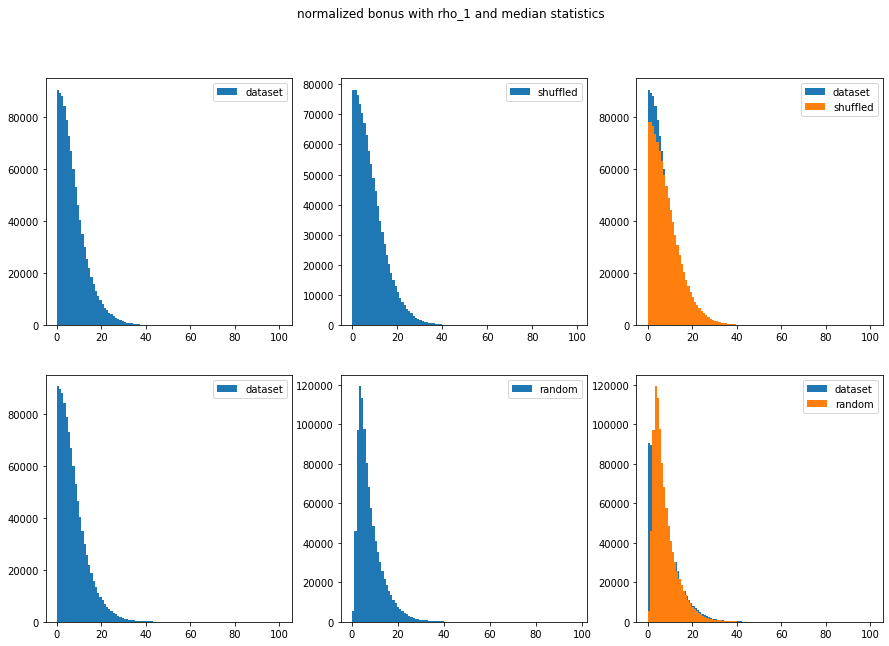

In [16]:
rho = rho1_median
matplotlib.rcParams['figure.figsize'] = (15, 10)
fig=plt.figure()
plt.subplot(2, 3, 1)
plt.hist(rho * bonus_1, bins = num_bins, label='dataset')
plt.legend()

plt.subplot(2, 3, 2)
plt.hist(rho * bonus_shuffled_1, bins = num_bins, label='shuffled')
plt.legend()

plt.subplot(2, 3, 3)
plt.hist(rho * bonus_1, bins = num_bins, label='dataset')
plt.hist(rho * bonus_shuffled_1, bins = num_bins, label='shuffled')
plt.legend(loc='upper right')


plt.subplot(2, 3, 4)
plt.hist(rho * bonus_1, bins = num_bins, label='dataset')
plt.legend()

plt.subplot(2, 3, 5)
plt.hist(rho * bonus_random_1_median, bins = num_bins, label='random')
plt.legend()

plt.subplot(2, 3, 6)
plt.hist(rho * bonus_1, bins = num_bins, label='dataset')
plt.hist(rho * bonus_random_1_median, bins = num_bins, label='random')
plt.legend(loc='upper right')

plt.suptitle('normalized bonus with rho_1 and median statistics')

###

In [17]:
b1 = (bonus_1 * rho1_mean).squeeze(1)
b2 = (bonus_1 * rho2_mean).squeeze(1)
b3 = (bonus_1 * rho1_median).squeeze(1)
print(b1.shape)
print(rewards.shape)
ratio_r_b1 = rewards / np.clip(b1, 1e-6, 1e9)
ratio_r_b2 = rewards / np.clip(b2, 1e-6, 1e9)
ratio_r_b3 = rewards / np.clip(b3, 1e-6, 1e9)


(1000000,)
(1000000,)


In [18]:
ratio_r_b1[:5]

array([1.1095327, 1.7270621, 1.1114465, 1.6546354, 3.8655996],
      dtype=float32)

Text(0.5, 0.98, 'ratio of reward to normalized bonus')

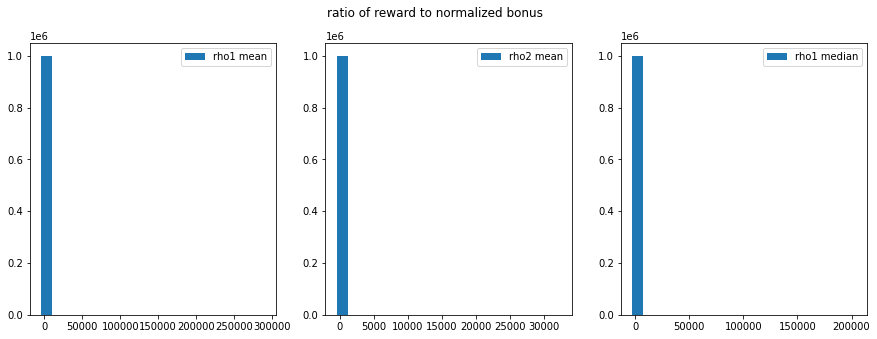

In [19]:
matplotlib.rcParams['figure.figsize'] = (15, 5)
num_bins = 20
fig=plt.figure()
plt.subplot(1, 3, 1)
plt.hist(ratio_r_b1, bins = num_bins, label='rho1 mean')
plt.legend()

plt.subplot(1, 3, 2)
plt.hist(ratio_r_b2, bins = num_bins, label='rho2 mean')
plt.legend()

plt.subplot(1, 3, 3)
plt.hist(ratio_r_b3, bins = num_bins, label='rho1 median')
plt.legend(loc='upper right')

plt.suptitle('ratio of reward to normalized bonus')


In [21]:
print('ratio 1:min:{:.2g}, max:{:0.2g}'.format(min(ratio_r_b1), max(ratio_r_b1)))
print('ratio 2:min:{:.2g}, max:{:0.2g}'.format(min(ratio_r_b2), max(ratio_r_b2)))
print('ratio 3:min:{:.2g}, max:{:0.2g}'.format(min(ratio_r_b3), max(ratio_r_b3)))

ratio 1:min:-4e+03, max:2.9e+05
ratio 2:min:-4.4e+02, max:3.2e+04
ratio 3:min:-2.8e+03, max:2e+05
